# Probability simplex projection

In [16]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

Here we can find implementaton of the 1st $\mathcal{O}(n \log n)$ algorithm, using Quicksort:

In [17]:
def project_simplex_sort(y):
    """
    Projects the vector y onto the unit simplex {x >= 0, sum(x) = 1}.
    Difficulty: O(n log n).
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    
    # If the sum is already <= 1 and all coordinates are non-negative,
    # then this is already a point on the simplex (you need to check).
    # But the classics usually assume sum(y) >= 1, 
    # nevertheless, we will add protection:
    if np.all(y >= 0) and np.abs(y.sum() - 1.0) < 1e-12:
        return y.copy()
    
    # Sort in descending order
    y_sorted = np.sort(y)[::-1]
    y_cumsum = np.cumsum(y_sorted)
    
    # Finding rho
    # We are looking for the largest k for which y_sorted[k] - (cumsum[k]-1)/(k+1) > 0
    rho = 0
    for k in range(n):
        val = y_sorted[k] - (y_cumsum[k] - 1.0)/(k + 1)
        if val > 0:
            rho = k + 1
    
    # Counting the theta threshold
    theta = (y_cumsum[rho - 1] - 1.0) / rho
    
    # Building x
    x = np.maximum(y - theta, 0.0)
    return x

And here we can find an implementation of an algorithm of average complexity $\mathcal{O}(n)$, but in the worst case $\mathcal{O}(n^2)$. The idea is that we consistently (as a recursive or iterative approach) search for the "pivot" threshold so that about half of the elements end up on one side of the threshold. Due to randomization, the average work time is obtained $\mathcal{O}(n)$:

In [18]:
def project_simplex_linear(y):
    """
    Projects the vector y onto the unit simplex,
    using the idea of a quick pivot selection.
    Average difficulty: O(n).
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    
    # If the sum is not more than 1 and y >= 0, then it is already in the simplex
    if np.all(y >= 0) and y.sum() <= 1.0:
        return y.copy()
    
    # Auxiliary function for recursive search
    def find_pivot_and_sum(indices, current_sum, current_count):
        if not indices:
            return current_sum, current_count, [], True
        
        # Randomly choosing the index for the pivot
        pivot_idx = random.choice(indices)
        pivot_val = y[pivot_idx]
        
        # Dividing the elements into >= pivot and < pivot
        bigger = []
        smaller = []
        sum_bigger = 0.0
        
        for idx in indices:
            val = y[idx]
            if val >= pivot_val:
                bigger.append(idx)
                sum_bigger += val
            else:
                smaller.append(idx)
        
        # Checking to see if we have reached the condition
        # sum_{waltz>= pivot_val} (val - pivot_val) < 1 ?
        # Considering that we already have current_sum/current_count
        new_sum = current_sum + sum_bigger
        new_count = current_count + len(bigger)
        
        # Condition: sum_{v>= pivot} (pivot) = new_sum - new_count * pivot
        # Compare with 1
        if (new_sum - new_count * pivot_val) < 1.0:
            # So pivot_val can still be (or higher)
            # -> moving towards the "smaller ones" (where we can raise the pivot)
            return (new_sum, new_count, smaller, False)
        else:
            # pivot_val is too big, we need to go to the "big ones",
            # i.e. those that are exactly >= pivot, we stay with them
            # (which may be even higher than the actual threshold).
            # But pivot_idx itself is also being removed from the proceedings. 
            # (since we know for sure that pivot_val < the true threshold).
            if pivot_idx in bigger:
                bigger.remove(pivot_idx)
                new_sum -= pivot_val
                new_count -= 1
            return (current_sum, current_count, bigger, False)
    
    indices = list(range(n))
    s = 0.0    
    c = 0      
    while indices:
        s, c, indices, done = find_pivot_and_sum(indices, s, c)
        if done:
            break
    
    # When finished, we have "rho =c" and "sum =s"
    # theta = (s - 1)/c
    theta = (s - 1.0)/c
    x = np.maximum(y - theta, 0)
    return x

Let's generate several large-dimensional vectors (for example, from $10.000$ to $500.000$) and measure the running time of both simplex projection algorithms:

dim=10000, time_sort=0.0037s, time_lin=0.0033s
dim=60000, time_sort=0.0153s, time_lin=0.0085s
dim=110000, time_sort=0.0227s, time_lin=0.0115s
dim=160000, time_sort=0.0325s, time_lin=0.0303s
dim=210000, time_sort=0.0428s, time_lin=0.0373s
dim=260000, time_sort=0.0510s, time_lin=0.0434s
dim=310000, time_sort=0.0610s, time_lin=0.0210s
dim=360000, time_sort=0.0708s, time_lin=0.0269s
dim=410000, time_sort=0.0802s, time_lin=0.0416s
dim=460000, time_sort=0.0919s, time_lin=0.0506s
dim=510000, time_sort=0.0997s, time_lin=0.0847s
dim=560000, time_sort=0.1141s, time_lin=0.0397s
dim=610000, time_sort=0.1240s, time_lin=0.1871s
dim=660000, time_sort=0.1349s, time_lin=0.0911s
dim=710000, time_sort=0.1449s, time_lin=0.1910s
dim=760000, time_sort=0.1525s, time_lin=0.1030s
dim=810000, time_sort=0.1680s, time_lin=0.0513s
dim=860000, time_sort=0.1702s, time_lin=0.1326s
dim=910000, time_sort=0.1824s, time_lin=0.1944s
dim=960000, time_sort=0.1931s, time_lin=0.1624s
dim=1010000, time_sort=0.2021s, time_lin=0

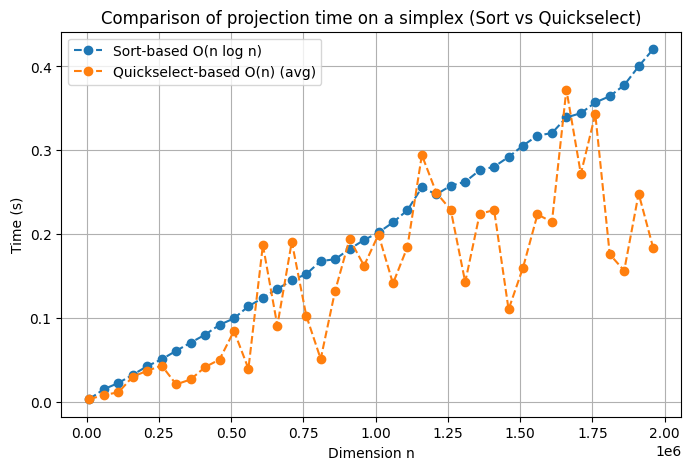

In [19]:
def check_projection_simplex(x, tol=1e-9):
    """
    Проверяет, что x проецирован на единичный симплекс:
    1) x_i >= 0 для всех i
    2) sum(x_i) ~ 1 (с некоторой точностью)
    """
    if (x < -tol).any():
        return False
    s = x.sum()
    return abs(s - 1.0) < tol

def generate_dims(start, stop, step):
    return np.arange(start, stop + step, step).tolist()

dims = generate_dims(10_000, 1_950_000, 50_000)
times_sort = []
times_linear = []

np.random.seed(42)

for d in dims:
    y = np.random.rand(d) * 2.0
    
    start = time.perf_counter()
    x_sort = project_simplex_sort(y)
    t_sort = time.perf_counter() - start
    
    start = time.perf_counter()
    x_lin = project_simplex_linear(y)
    t_lin = time.perf_counter() - start
    
    times_sort.append(t_sort)
    times_linear.append(t_lin)
    
    assert check_projection_simplex(x_sort), "Sort-based projection incorrect!"
    assert check_projection_simplex(x_lin),  "Linear-based projection incorrect!"
    
    print(f"dim={d}, time_sort={t_sort:.4f}s, time_lin={t_lin:.4f}s")

# Построим графики
plt.figure(figsize=(8, 5))
plt.plot(dims, times_sort, 'o--', label='Sort-based O(n log n)')
plt.plot(dims, times_linear, 'o--', label='Quickselect-based O(n) (avg)')
plt.xlabel('Dimension n')
plt.ylabel('Time (s)')
plt.title('Comparison of projection time on a simplex (Sort vs Quickselect)')
plt.legend()
plt.grid(True)
plt.show()

Thus, we see that the second algorithm is always superior to the first one on average, but in some few cases the first one is superior to the second one. Apparently, in these cases, the most "inconvenient " cases for the second algorithm are implemented.